In [1]:
import os
import pickle
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pypmml import Model
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn2pmml import sklearn2pmml
from sklearn2pmml.pipeline import PMMLPipeline
from datetime import datetime, timedelta
from nyoka import skl_to_pmml
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv("TransformedData.csv")
df['Posted Time'] = pd.to_datetime(df['Posted Time'], format="%d/%m/%Y")
print(df.head())

  Posted Time     Width    Length  Floors  Rooms  Toilets  Price per m2  \
0  2025-01-31  2.236068  4.472136     0.0    0.0      0.0      1.252763   
1  2025-02-01  2.236068  4.472136     0.0    0.0      0.0      1.252763   
2  2025-01-13  2.236068  3.872983     0.0    0.0      0.0      1.554630   
3  2025-02-07  2.236068  5.477226     0.0    0.0      0.0      1.311683   
4  2025-02-02  2.236068  4.472136     0.0    0.0      0.0      1.791759   

   1 Part Residential  All Residential  Back Expansion  ...  \
0                   1                0               1  ...   
1                   0                0               1  ...   
2                   0                0               0  ...   
3                   1                0               0  ...   
4                   0                0               1  ...   

   House Direction_SOUTHWEST  House Direction_WEST  \
0                        0.0                   0.0   
1                        0.0                   1.0   
2       

In [3]:
df['year'] = df['Posted Time'].dt.year
df['month'] = df['Posted Time'].dt.month
df['day'] = df['Posted Time'].dt.day
df['dayofweek'] = df['Posted Time'].dt.dayofweek
df['quarter'] = df['Posted Time'].dt.quarter

# Cyclical features
df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
df['dayOfWeek_sin'] = np.sin(2 * np.pi * df['dayofweek'] / 7)
df['dayOfWeek_cos'] = np.cos(2 * np.pi * df['dayofweek'] / 7)

df.drop(columns=['Posted Time'], inplace=True)

In [4]:
y = df['Price per m2']
X = df.drop('Price per m2', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"X_train: {X_train.shape}, X_test: {X_test.shape}")
# train = pd.read_csv("train.csv")
# test  = pd.read_csv("test.csv")

# X_train = train.drop("Price per m2", axis=1)
# y_train = train["Price per m2"]
# X_test  = test.drop("Price per m2", axis=1)
# y_test  = test["Price per m2"]

X_train: (12431, 45), X_test: (3108, 45)


In [ ]:
def export_base_models_to_pmml(model_path, model_name, output_pmml_path):
    try:
        print(f"\n>>> Exporting {model_name} to PMML...")
        
        # Load the pre-trained model
        model = pickle.load(open(model_path, "rb"))
        
        # Create a PMMLPipeline
        pipeline = PMMLPipeline([
            ("estimator", model)
        ])
        
        # Fit the pipeline on training data to ensure proper PMML export
        pipeline.fit(X_train, y_train)
        
        # Export to PMML
        sklearn2pmml(pipeline, output_pmml_path, with_repr=True)
        print(f"✅ {model_name} exported successfully to {output_pmml_path}")
        
    except Exception as e:
        print(f"❌ Failed to export {model_name}: {str(e)}")

# # Export individual models to PMML
# export_base_models_to_pmml("random_forest_final_model.pkl", "Random Forest", "random_forest_model.pmml")
# export_base_models_to_pmml("xgboost_final_model.pkl", "XGBoost", "xgboost_model.pmml")
# export_base_models_to_pmml("lightgbm_final_model.pkl", "LightGBM", "lightgbm_model.pmml")
# export_base_models_to_pmml("ridge_regression_model.pkl", "Ridge", "ridge_regression_model.pmml")
# export_base_models_to_pmml("linear_regression_model.pkl", "Linear Regression", "linear_regression_model.pmml")

In [ ]:
# def export_base_models_to_pmml(model_path, model_name, output_pmml_path, X_sample=None, y_sample=None):
#     try:
#         print(f"\n>>> Exporting {model_name} to PMML...")

#         # Load the pre-trained model
#         model = pickle.load(open(model_path, "rb"))

#         # Create dummy data if X_sample or y_sample are not provided
#         if X_sample is None or y_sample is None:
#             n_features = getattr(model, "n_features_in_", 10)
#             X_sample = np.zeros((1, n_features))  # Dummy data for feature input
#             y_sample = np.zeros(1)  # Dummy data for target output
        
#         # Ensure directory exists
#         os.makedirs(os.path.dirname(output_pmml_path), exist_ok=True)

#         # Convert the model to PMML using nyoka
#         skl_to_pmml(model, X_sample, y_sample, output_pmml_path)
        
#         print(f"✅ {model_name} exported successfully to {output_pmml_path}")
    
#     except Exception as e:
#         print(f"❌ Failed to export {model_name}: {str(e)}")

In [7]:
base_models = [
    ("RandomForest",   pickle.load(open("random_forest_final_model.pkl",   "rb"))),
    ("XGBoost",        pickle.load(open("xgboost_final_model.pkl",        "rb"))),
    ("LightGBM",       pickle.load(open("lightgbm_final_model.pkl",       "rb"))),
    ("Ridge",          pickle.load(open("ridge_regression_model.pkl",     "rb"))),
    ("LinearReg",      pickle.load(open("linear_regression_model.pkl",    "rb")))
]
for name, _ in base_models:
    print(f"  • {name} loaded")

  • RandomForest loaded
  • XGBoost loaded
  • LightGBM loaded
  • Ridge loaded
  • LinearReg loaded


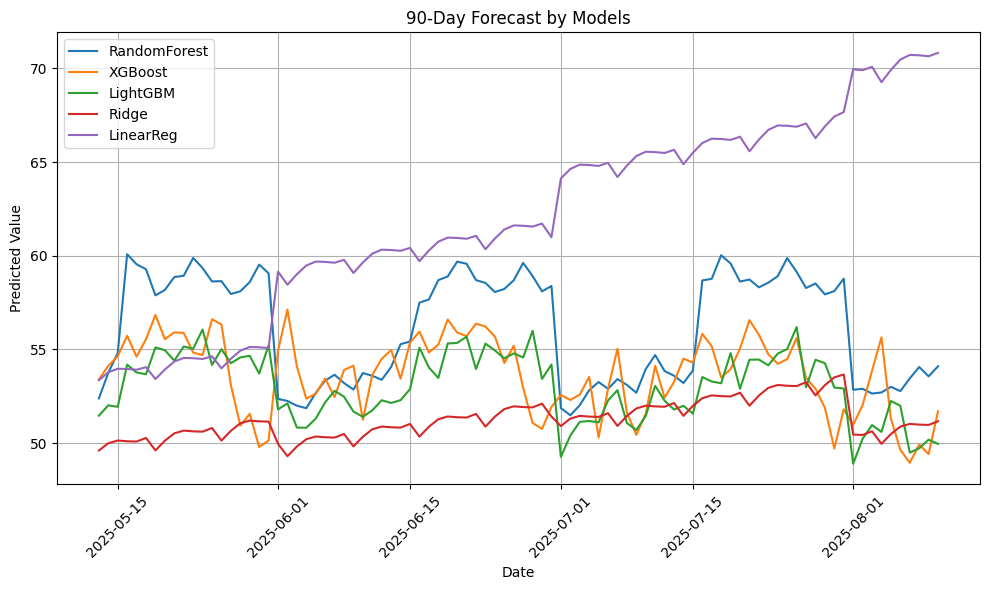

In [8]:
base = X_test.iloc[-1].copy()

start_date = pd.Timestamp.now().normalize()

days = [start_date + timedelta(days=i) for i in range(90)]

results = {'Date': days}

for name, model in base_models:
    preds = []
    for date in days:
        f = base.copy()
        f['year']      = date.year
        f['month']     = date.month
        f['day']       = date.day
        f['dayofweek'] = date.weekday()
        f['quarter']   = date.quarter
        
        f['month_sin']     = np.sin(2 * np.pi * f['month'] / 12)
        f['month_cos']     = np.cos(2 * np.pi * f['month'] / 12)
        f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
        f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)

        X_pred = f.values.reshape(1, -1)
        pred = model.predict(X_pred)[0]

        pred = np.expm1(pred)

        preds.append(pred)

    results[name] = preds

forecast_df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
for name in forecast_df.columns[1:]:
    plt.plot(forecast_df['Date'], forecast_df[name], label=name)

plt.title('90-Day Forecast by Models')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [9]:
stack = StackingRegressor(
    estimators=base_models,
    final_estimator=Ridge(random_state=42),
    cv=5,
    n_jobs=-1,
)

# param_grid = {
#     "final_estimator__alpha": [0.01, 0.1, 0.5, 0.9, 1.0, 5.0, 10.0, 50.0, 100.0],
#     "final_estimator__fit_intercept": [True, False],
#     "final_estimator__solver": ['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']
# }

param_grid = {
    "final_estimator__alpha": [0.5],
    "final_estimator__fit_intercept": [True],
    "final_estimator__solver": ['lsqr']
}

grid = GridSearchCV(
    stack,
    param_grid=param_grid,
    scoring="neg_mean_squared_error",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

best_stack = grid.best_estimator_
print("Best params:", grid.best_params_)

Fitting 3 folds for each of 1 candidates, totalling 3 fits
Best params: {'final_estimator__alpha': 0.5, 'final_estimator__fit_intercept': True, 'final_estimator__solver': 'lsqr'}


In [10]:
# stack = StackingRegressor(
#     estimators=base_models,
#     final_estimator=RandomForestRegressor(random_state=42),
#     cv=5,
#     n_jobs=-1,
# )

# # Cập nhật param_grid cho RandomForest
# param_grid = {
#     "final_estimator__n_estimators": [300], # Số lượng cây
#     "final_estimator__max_depth": [15],   # Độ sâu tối đa của cây
#     "final_estimator__min_samples_split": [5],    # Số mẫu tối thiểu để chia một node
#     "final_estimator__min_samples_leaf": [2],      # Số mẫu tối thiểu ở một lá
# }

# grid = GridSearchCV(
#     stack,
#     param_grid=param_grid,
#     scoring="neg_mean_squared_error",
#     cv=3,
#     n_jobs=-1,
#     verbose=1
# )

# grid.fit(X_train, y_train)

# best_stack = grid.best_estimator_
# print("Best params:", grid.best_params_)

In [11]:
print("\n--- Evaluation ---")
# Training
y_pred_train = best_stack.predict(X_train)
mse = mean_squared_error(y_train, y_pred_train)
print(f"Train  — MSE: {mse:.4f}, RMSE: {np.sqrt(mse):.4f}, MAE: {mean_absolute_error(y_train, y_pred_train):.4f}, R2: {r2_score(y_train, y_pred_train):.4f}")

# Testing
y_pred_test = best_stack.predict(X_test)
mse = mean_squared_error(y_test, y_pred_test)
print(f"Test   — MSE: {mse:.4f}, RMSE: {np.sqrt(mse):.4f}, MAE: {mean_absolute_error(y_test, y_pred_test):.4f}, R2: {r2_score(y_test, y_pred_test):.4f}")

print("\n--- Base Models Evaluation on Test Set ---")
for name, model in base_models:
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name:15} — MSE: {mse:.4f}, RMSE: {rmse:.4f}, MAE: {mae:.4f}, R2: {r2:.4f}")


--- Evaluation ---
Train  — MSE: 0.0505, RMSE: 0.2246, MAE: 0.1617, R2: 0.8244
Test   — MSE: 0.0846, RMSE: 0.2909, MAE: 0.2127, R2: 0.7080

--- Base Models Evaluation on Test Set ---
RandomForest    — MSE: 0.0487, RMSE: 0.2206, MAE: 0.1578, R2: 0.8320
XGBoost         — MSE: 0.0880, RMSE: 0.2966, MAE: 0.2173, R2: 0.6964
LightGBM        — MSE: 0.0887, RMSE: 0.2979, MAE: 0.2187, R2: 0.6938
Ridge           — MSE: 0.1118, RMSE: 0.3344, MAE: 0.2515, R2: 0.6141
LinearReg       — MSE: 0.1120, RMSE: 0.3347, MAE: 0.2516, R2: 0.6135


In [12]:
# Cell 6: Save stacking model and export all to PMML
pickle.dump(best_stack, open("stacking_forecast_model.pkl", "wb"))
print("stacking_forecast_model.pkl saved")
pipe = PMMLPipeline([("estimator", best_stack)])
pipe.fit(X_train, y_train)
sklearn2pmml(pipe, "stacking_forecast_model.pmml", with_repr=True)
print("stacking_forecast_model.pmml saved")

stacking_forecast_model.pkl saved
stacking_forecast_model.pmml saved


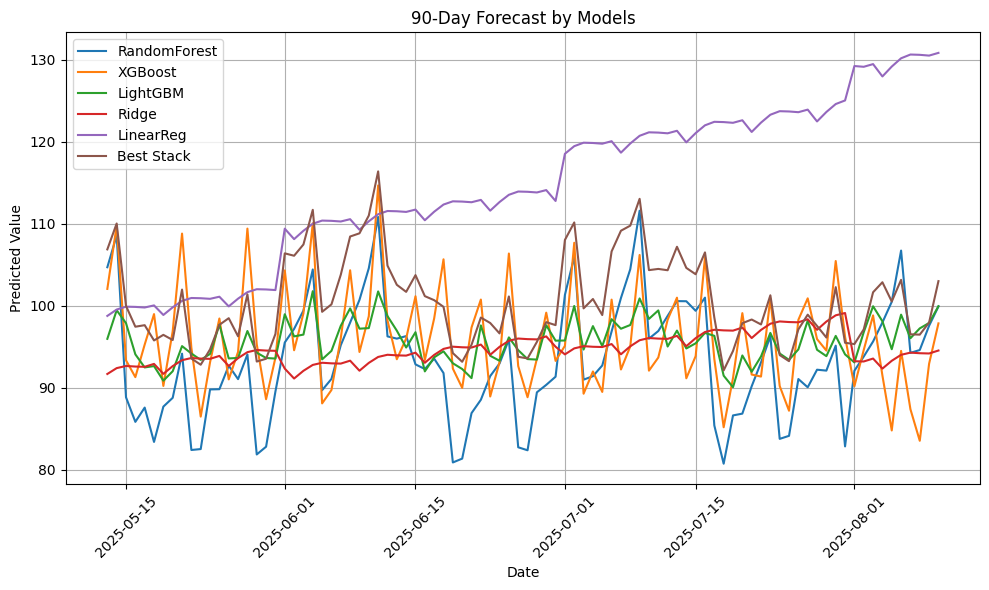

In [13]:
# Load the PMML model
best_stack = Model.load("stacking_forecast_model.pmml")
base = X.iloc[-1].copy()
# Define your base models
models_to_forecast = base_models + [('Best Stack', best_stack)]

# Set up your forecast start date and range
start_date = pd.Timestamp.now().normalize()
days = [start_date + timedelta(days=i) for i in range(90)]

results = {'Date': days}

for name, model in models_to_forecast:
    preds = []
    for date in days:
        f = base.copy()
        f['year']      = date.year
        f['month']     = date.month
        f['day']       = date.day
        f['dayofweek'] = date.weekday()
        f['quarter']   = date.quarter

        # Create sine and cosine transformations
        f['month_sin']     = np.sin(2 * np.pi * f['month'] / 12)
        f['month_cos']     = np.cos(2 * np.pi * f['month'] / 12)
        f['dayOfWeek_sin'] = np.sin(2 * np.pi * f['dayofweek'] / 7)
        f['dayOfWeek_cos'] = np.cos(2 * np.pi * f['dayofweek'] / 7)

        X_pred = f.values.reshape(1, -1)

        pred = model.predict(X_pred)[0]

        # Apply inverse transformation to predictions
        pred = np.expm1(pred)
        preds.append(pred)

    results[name] = preds

# Convert results to DataFrame
forecast_df = pd.DataFrame(results)

# Plot the forecast results
plt.figure(figsize=(10, 6))
for name in forecast_df.columns[1:]:
    plt.plot(forecast_df['Date'], forecast_df[name], label=name)

plt.title('90-Day Forecast by Models')
plt.xlabel('Date')
plt.ylabel('Predicted Value')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()